### Setup

In [16]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

# Report

## Introduction and data

> REMOVE THE FOLLOWING TEXT

This section includes an introduction to the project motivation, data, and research question.
Describe the data and definitions of key variables.

It should also include some exploratory data analysis.

All of the EDA won't fit in the paper, so focus on the EDA for the response variable and a few other interesting variables and relationships.

## Methodology

### Classification

For our classification, we are using a Logistic Regression model to predict the Happiness of German people based on different social, political, and financial aspects. As a predictor variable, we select the variable "happy" from our data set, which reflects a person's self-assessment of happiness on a scale of 0 to 10.

Fortunately, the dataset did not contain a single row with a missing value at the response variable “happy”. Thus, we were able to use the whole dataset for our model.

Since the variable can have 11 valid values (0 for "not happy" to 10 for "happy"), the values must first be categorized, since logistic regression can only make binary predictions. 
We would like to have a balanced dataset containing a similar number of "happy" and "unhappy" people in our dataset. That's why we set the threshold to different values. By doing this, we can try to balance out the dataset.
The easiest way to categorize these values into two categories, is to split at the value 5. 

First, the value 5 will be included to the "happy" category.

In [17]:
cls_df = pd.read_csv("../data/interim/cls_df_pre_bin")

In [18]:
cls_df_happy5 = cls_df.copy()
cls_df_happy5['happy'] = cls_df_happy5['happy'].apply(lambda x: 1 if x >= 5 else 0)

cls_df_happy5['happy'].value_counts()

happy
1    2781
0     250
Name: count, dtype: int64

By looking at the count of the values, it's clear to see that there are far more people being "happy" than there are being "unhappy". Next, we compare this result with the next split at the value 6.

In [19]:
cls_df_happy6 = cls_df.copy()
cls_df_happy6['happy'] = cls_df_happy6['happy'].apply(lambda x: 1 if x >= 6 else 0)

cls_df_happy6['happy'].value_counts()

happy
1    2466
0     565
Name: count, dtype: int64

By splitting the data at the value 6, the distribution is more balanced than before. Still, it is not optimal for training our model. This issue will be handled later.

We manually picked some predictor variables out of all the 674 variables included in the dataset which seem to the suitable for predicting the happiness score. Due to the high number of variables, we could not analyse every single one. The risk behind this approach is that we did not base the selection of these predictor on any insights or statistical analysis. Thus, the selected variables might not be suitable for our model. 
Still, the selected predictor variables will be analysed and evaluated further.

After binning the values of the response variable “happy”, we aim to clean the predictor variables by either dropping variables containing a high percentage of missing values or replace the missing values. Three predictor variables really stood out when visualizing the percentage of missing values: “dsgrmnya”, “edude2” and “wrywprb” contained at least 40% missing values. Due to this high number of missing values, a replacement value would most likely not represent the “real” value, so we dropped these variables. The remaining predictor variables either had none or not more than 10% missing values. Depending on the respective variable being ordinal or nominal, we filled the missing values by using the median for ordinal variables and the mode for nominal variables. 

The data splitting process divided the dataset into training and test data. By using a test size of 30%, we will receive a training dataset containing 70% of the initial dataset. To further analyse our dataset and gain insights to improve the performance of our model, we first perform an explanatory data analysis (EDA) on the training data.

The feature selection process was based entirely on the EDA containing a correlation matrix as well as a computation of the Variance Inflation Factor (VIF) which indicates multicollinearity across predictor variables. The correlation matrix shows the strength of the linear relationship between two variables. The goal was to determine variables having a high correlation coefficient and to eliminate these variables to prevent multicollinearity. Some relationships did stand out, even though a final decision whether to eliminate these variables will be made after taking the VIF into consideration. 

For the VIF, we aim for a value below 10, at best even below 5. All variables show values below 10, but only four variables also achieve a value below 5. After considering the results of the correlation matrix, five predictor variables are eliminated leaving our dataset with seven predictor variables. 

After selecting all relevant features for our modeling process there is still one issue to handle. As described previously, we had to categorize the values of our response variable “happy” in to two categories. Only by doing this, we can apply a logistic regression model to this problem. The categorization leaves us with two valid values for our response variable: “happy” and “unhappy”. By looking at the count of these values, it’s clear to see that there are much more of “happy” people than there are of “unhappy” people. This imbalance will be addressed by oversampling the training data. 

Oversampling is a method which randomly selects a sample out of the training data, copies it and repeats this process until the dataset is fully balanced. To evaluate whether oversampling improves the performance our model, we will train a model using the original, unbalanced dataset and train another model using the balanced, oversampled dataset. The reason to not use undersampling is that we do not want to lose out on information.

## Results

### Classification

In [20]:
cls_data = pd.read_csv("../data/processed/cls_final.csv")

X_cls_test = cls_data.loc[2121:].drop("happy", axis=1)
y_cls_test = cls_data.loc[2121:][["happy"]]

First, we will evaluate the model trained on the unbalanced dataset. 

We achieve an accuracy of 82.2% when testing the model with our dedicated test data. This accuracy is a quite good score for our model. When plotting the confusion matrix, we can see how our model predicted the test data. 

In [21]:
model_cls_unbal = pickle.load(open("../models/log-reg_unbal.pkl", "rb"))

In [22]:
y_pred_unbal = model_cls_unbal.predict(X_cls_test)

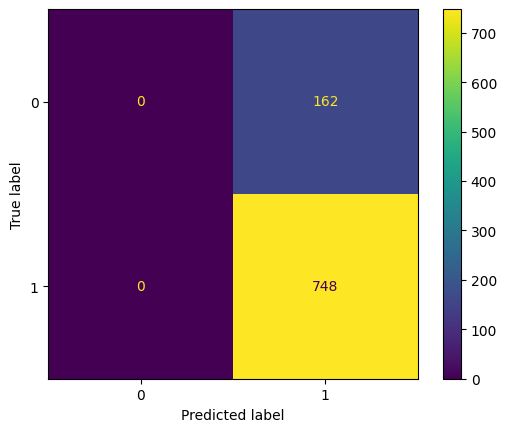

In [23]:
ConfusionMatrixDisplay.from_predictions(y_cls_test, y_pred_unbal, display_labels=model_cls_unbal.classes_)

The confusion matrix shows that our model predicted every data in our test data to be “happy”. Not a single entry was predicted to be “unhappy”. This explains the high accuracy score. We do not aim to have a model which only predicts people to be happy. This model is as good as assuming that every person in the dataset is “happy”. Even after adjusting the decision threshold to 0.6 and 0.7, not a single entry was predicted to be “unhappy”. Thus, this model will not be further evaluated.

Next, we train a new model with our oversampled, balanced dataset. 
This model achieves an accuracy score of about 59.3%. Compared to the previous model, this value is significantly worse. By looking at the confusion matrix, we see that this model did also predict “unhappy” which is an improvement compared to the previous model. Still, performance is quite bad as many entries which are “happy” got predicted to be “unhappy”. 

In [24]:
model_cls_bal = pickle.load(open("../models/log-reg.pkl", "rb"))

In [25]:
y_pred_bal = model_cls_bal.predict(X_cls_test)

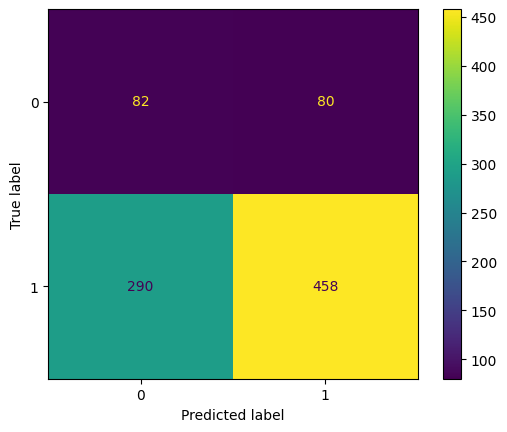

In [26]:
ConfusionMatrixDisplay.from_predictions(y_cls_test, y_pred_bal, display_labels=model_cls_bal.classes_)

In [27]:
print(classification_report(y_cls_test, y_pred_bal, target_names=["unhappy", "happy"]))

              precision    recall  f1-score   support

     unhappy       0.22      0.51      0.31       162
       happy       0.85      0.61      0.71       748

    accuracy                           0.59       910
   macro avg       0.54      0.56      0.51       910
weighted avg       0.74      0.59      0.64       910



We aim to optimize recall as we want to know what proportion of people got predicted correctly. 
By looking at the data whose true label is “unhappy” (or 0), the recall score is at 0.51. The recall score of “happy” people is at 0.61 which is a bit better, but still leaves a lot of room for optimization.

The ROC-curve (receiver operating characteristic) shows the performance of a classification model at different classification thresholds. The AUC-score (area under curve) provides an aggregate measure of performance across all possible classification thresholds. 

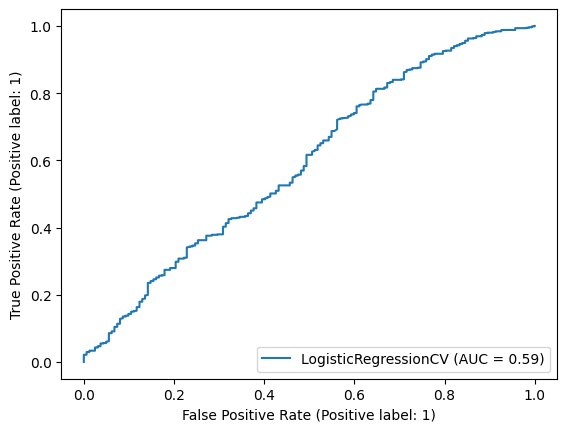

In [28]:
RocCurveDisplay.from_estimator(model_cls_bal, X_cls_test, y_cls_test)

The ROC-curve is quite flat and close to a straight line. The AUC-score is at 0.59 which is close to the value 0.5 indicating a randomized prediction. This shows that the model trained on the balanced dataset is anything but good.

In [29]:
pred_proba = model_cls_bal.predict_proba(X_cls_test)

df = pd.DataFrame({"y_pred": pred_proba[:,1] > 0.4})

print(f"Logistic Regression with Threshold {0.4}")

print(classification_report(y_cls_test, df["y_pred"], target_names=["unhappy", "happy"]))

Logistic Regression with Threshold 0.4
              precision    recall  f1-score   support

     unhappy       0.30      0.29      0.29       162
       happy       0.85      0.85      0.85       748

    accuracy                           0.75       910
   macro avg       0.57      0.57      0.57       910
weighted avg       0.75      0.75      0.75       910



We try to optimize our model by using different classification thresholds using the recall score. By comparing different classification thresholds, we achieve the highest recall and F1-score at the threshold 0.4 with a recall score of 0.57 and a F1-score of also 0.57.

This model shows that the predictor variables do not really contribute to making a clear decision whether a person is happy or not. This issue was already addressed at the beginning stating that based on our manual variable selection we risk choosing variables which might not be suitable for the purpose of our model. This statement can now be confirmed.

## Discussion + Conclusion


> REMOVE THE FOLLOWING TEXT

In this section you'll include a summary of what you have learned about your research question along with statistical arguments supporting your conclusions.
In addition, discuss the limitations of your analysis and provide suggestions on ways the analysis could be improved.
Any potential issues pertaining to the reliability and validity of your data and appropriateness of the statistical analysis should also be discussed here.
Lastly, this section will include ideas for future work.